# Ali Flu Project 10x - FNA Samples from P04, P05 and P11 (Year 1 and Year2)
* Hailong

In [1]:
## load libraries ####
rm(list=ls())
start_time <- Sys.time()
suppressPackageStartupMessages(library("dplyr"))
suppressPackageStartupMessages(library("ggplot2"))
suppressPackageStartupMessages(library("Seurat"))
suppressPackageStartupMessages(library("cowplot"))
suppressPackageStartupMessages(library("pheatmap"))
suppressPackageStartupMessages(library("RColorBrewer"))
suppressPackageStartupMessages(library("Matrix"))
suppressPackageStartupMessages(library("alakazam"))
suppressPackageStartupMessages(library("tidyr"))
suppressPackageStartupMessages(library("gridExtra"))
suppressPackageStartupMessages(library("grid"))
suppressPackageStartupMessages(library("scales"))
sampleCat = "FNA"
path.work = file.path("D:","Storage","Ali","10x", "Year2", "GEX", sampleCat)
path.data = file.path("C:","Project","workspace", "AliFlu","10x", "data")
setwd(path.work)
feature.cols = c("lightgray", "blue")

# Load mappings
mapping.file = file.path(path.data, "data_mapping", "map_GEX.txt")
mappings = read.delim(mapping.file, stringsAsFactors = FALSE, as.is=T)
mappings = filter(mappings, SampleType == "FNA")
dim(mappings)

Warning message:
"package 'dplyr' was built under R version 3.6.3"
Warning message:
"package 'ggplot2' was built under R version 3.6.3"
Warning message:
"package 'cowplot' was built under R version 3.6.1"
Warning message:
"package 'alakazam' was built under R version 3.6.3"
Warning message:
"package 'tidyr' was built under R version 3.6.3"


[1] 47  8

In [34]:
# Read in immunestates file
immunostates_file <- file.path(path.data, "immunostates.txt")
immunostates <- read.table(immunostates_file,header = TRUE,sep="\t") %>%
    gather("KNOWN", "EXPR", -Gene) %>%
    rename(GENE = Gene) %>%
    mutate(EXPR = log(EXPR))

In [35]:
# load saved meta pulled from Ensembl 93 using biomaRt
load(file.path(path.data, "QC_features_meta.RData"))

# CellRanger will always return the same number of features in the GEX matrix 
# as long as the same 10x reference is used 
# In this case, for the reference I used, it's 33538 features
dim(features_meta)
#[1] 33538     5

# biotypes of features
# The IG_ and TR_ ones are the ones to exclude
table(features_meta[["gene_biotype"]])
 
# get a vector of IG and TR genes 
# do this by subsetting $gene_biotype (as opposed to basing off gene names)
biotypes_excl = unique(features_meta[["gene_biotype"]])[grepl(pattern="^IG_|^TR_", x=unique(features_meta[["gene_biotype"]]))]
remove.genes = features_meta[["external_gene_name"]][features_meta[["gene_biotype"]] %in% biotypes_excl]

[1] 33538     5


      antisense       IG_C_gene IG_C_pseudogene       IG_D_gene       IG_J_gene 
           5497              14               9              37              18 
IG_J_pseudogene       IG_V_gene IG_V_pseudogene         lincRNA  protein_coding 
              3             144             188            7484           19912 
      TR_C_gene       TR_D_gene       TR_J_gene TR_J_pseudogene       TR_V_gene 
              6               4              79               4             106 
TR_V_pseudogene 
             33 

## Read in data and apply filters¶

In [36]:
obj_list <- list()
gene_use=c()
for(samplePath in mappings$SamplePath){     
    sample = mappings$SampleName[which(mappings$SamplePath == samplePath)]
    sample2 = mappings$SampleName2[which(mappings$SamplePath == samplePath)]
    sampleType = mappings$SampleType[which(mappings$SamplePath == samplePath)]
    day = mappings$Day[which(mappings$SamplePath == samplePath)]
    subject = mappings$Subject[which(mappings$SamplePath == samplePath)]
    year = mappings$Year[which(mappings$SamplePath == samplePath)]
    cat(sample, '\n')    
    dir.name.full = paste0(path.data, samplePath,"/outs/filtered_feature_bc_matrix")
    cat(dir.name.full, '\n')
    data <- Read10X(data.dir = dir.name.full)
    obj <- CreateSeuratObject(counts = data, project = sample, min.cells = 5, min.features = 400)
    obj$sampleName <- sample
    obj$sampleName2 <- sample2
    obj$sampleType <- sampleType
    obj$day <- day
    obj$subject <- subject
    obj$subject_year <- paste(subject, year, sep="_")
                         
    #colnames(data) <- sapply(colnames(data), function(x) paste(sample, x, sep = '_'))
    obj <- RenameCells(object = obj, add.cell.id = sample)
    obj[["percent.mt"]] <- PercentageFeatureSet(object = obj, pattern = "^MT-")
    gene.cutoff.high=7000
    obj <- subset(x = obj, subset = nFeature_RNA > 400 & nFeature_RNA < gene.cutoff.high & percent.mt < 15)
  
    obj <- NormalizeData(object = obj, normalization.method = "LogNormalize", scale.factor = 10000)
    obj_list[[sample]] <- obj
    
}


P04_FNA_d0_1_Y1 
C:/Project/workspace/AliFlu/10x/data/ellebedy_10x_P04/cr_gex/WU321-04-d0_FNA-lib1/outs/filtered_feature_bc_matrix 
P04_FNA_d0_2_Y1 
C:/Project/workspace/AliFlu/10x/data/ellebedy_10x_P04/cr_gex/WU321-04-d0_FNA_2-lib1/outs/filtered_feature_bc_matrix 
P04_FNA_d0_1_Y2 
C:/Project/workspace/AliFlu/10x/data/ellebedy_10x_P04/cr_gex/WUs321-04-s0_FNA-lib1/outs/filtered_feature_bc_matrix 
P04_FNA_d0_2_Y2 
C:/Project/workspace/AliFlu/10x/data/ellebedy_10x_P04/cr_gex/WUs321-04-s0_FNA_2-lib1/outs/filtered_feature_bc_matrix 
P04_FNA_d5_1_Y1 
C:/Project/workspace/AliFlu/10x/data/ellebedy_10x_P04/cr_gex/WU321-04-d5_FNA-lib1/outs/filtered_feature_bc_matrix 
P04_FNA_d5_2_Y1 
C:/Project/workspace/AliFlu/10x/data/ellebedy_10x_P04/cr_gex/WU321-04-d5_FNA_2-lib1/outs/filtered_feature_bc_matrix 
P04_FNA_d12_1_Y1 
C:/Project/workspace/AliFlu/10x/data/ellebedy_10x_P04/cr_gex/WU321-04-d12_FNA-lib1/outs/filtered_feature_bc_matrix 
P04_FNA_d12_2_Y1 
C:/Project/workspace/AliFlu/10x/data/ellebedy_10

## Read in data and apply filters¶

In [37]:
samples = mappings$SampleName
samples.left = samples[-c(1,2)]
immune.combined <- merge(obj_list[[samples[1]]] , obj_list[[samples[2]]])
for(sample in samples.left){
    immune.combined <- merge(immune.combined ,  obj_list[[sample]])
}
# remove obj_list & obj & data to save space
rm(obj)
rm(data)
rm(obj_list)
gc()
#saveRDS(immune.combined, file.path(path.work, paste0(sampleCat,"_pre.GEX.rds")))

used       (Mb)   gc trigger (Mb)    max used    (Mb)    
Ncells    3135298  167.5    7405610   395.6     7405610    395.6
Vcells 1182684708 9023.2 5069444763 38676.8 14306834645 109152.5

## Number of cells in each sample after filtering

In [38]:
cell.count = as.matrix(table(Idents(immune.combined)))
colnames(cell.count) = "Cell Count"
cell.count

Cell Count
P04_FNA_d0_1_Y1   5216      
P04_FNA_d0_1_Y2   4823      
P04_FNA_d0_2_Y1   4925      
P04_FNA_d0_2_Y2   4403      
P04_FNA_d12_1_Y1  5112      
P04_FNA_d12_2_Y1  4750      
P04_FNA_d120_1_Y1 4608      
P04_FNA_d120_2_Y1 4434      
P04_FNA_d14_1_Y2  4966      
P04_FNA_d14_2_Y2  4542      
P04_FNA_d5_1_Y1   3542      
P04_FNA_d5_2_Y1   5687      
P04_FNA_d60_1_Y2  1679      
P04_FNA_d60_2_Y2  3554      
P04_FNA_d90_1_Y2  3811      
P04_FNA_d90_2_Y2  4663      
P05_FNA_d0_1_Y1   6501      
P05_FNA_d0_1_Y2   6335      
P05_FNA_d0_2_Y1   5935      
P05_FNA_d0_2_Y2   5316      
P05_FNA_d0_3_Y2   6317      
P05_FNA_d12_1_Y1  7232      
P05_FNA_d12_2_Y1  5706      
P05_FNA_d12_3_Y1  7041      
P05_FNA_d120_1_Y2 4422      
P05_FNA_d120_2_Y2 4290      
P05_FNA_d120_3_Y2 4833      
P05_FNA_d120_4_Y2 4965      
P05_FNA_d180_1_Y1 9338      
P05_FNA_d180_2_Y1 6157      
P05_FNA_d28_1_Y2  5543      
P05_FNA_d28_2_Y1  6366      
P05_FNA_d28_2_Y2  5849      
P05_FNA_d28_3_Y1  6235      
P05_FNA_d28_3_Y2  5348      
P05_FNA_d5_1_Y1   8515      
P05_FNA_d5_2_Y1   6708      
P05_FNA_d60_1_Y1  5587      
P05_FNA_d60_1_Y2  5418      
P05_FNA_d60_2_Y1  5637      
P05_FNA_d60_2_Y2  5739      
P05_FNA_d60_3_Y2  4617      
P05_FNA_d7_1_Y2   7423      
P05_FNA_d7_2_Y2   6654      
P05_FNA_d7_3_Y2   7032      
P05_FNA_d90_1_Y1  5737      
P05_FNA_d90_2_Y1  6540

After remvoing IG/TR genes, total gene count is:  1721 


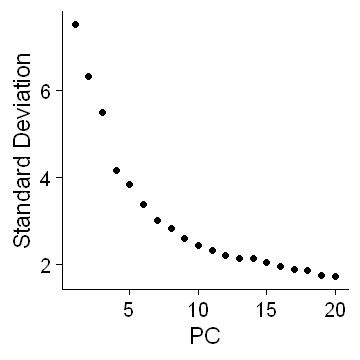

In [39]:
# Run the standard workflow for visualization and clustering
immune.combined <- ScaleData(object = immune.combined, verbose = FALSE)
immune.combined <- FindVariableFeatures(immune.combined, selection.method = "vst", nfeatures = 2000, do.plot = F)
bool.remove.genes <- immune.combined@assays$RNA@var.features %in% remove.genes
immune.combined@assays$RNA@var.features = immune.combined@assays$RNA@var.features[!bool.remove.genes]                     
cat('After remvoing IG/TR genes, total gene count is: ', length(immune.combined@assays$RNA@var.features), '\n')
immune.combined <- RunPCA(object = immune.combined, npcs = 30, verbose = FALSE)
options(repr.plot.width=3, repr.plot.height=3)
ElbowPlot(object = immune.combined)

In [40]:
# save for future use
saveRDS(immune.combined, file.path(path.work, "FNA.GEX.Y1Y2_pre.rds"))
#immune.combined <- readRDS("FNA.GEX.rds")

In [41]:
# UMAP and Clustering
immune.combined <- RunUMAP(object = immune.combined, reduction = "pca", dims = 1:20)
immune.combined <- FindNeighbors(object = immune.combined, reduction = "pca", dims = 1:20)
immune.combined <- FindClusters(immune.combined, resolution = 0.6)

Computing nearest neighbor graph
Computing SNN


Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 260051
Number of edges: 6669687

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9184
Number of communities: 29
Elapsed time: 195 seconds


4 singletons identified. 25 final clusters.


In [42]:
immune.combined$sampleName = factor(immune.combined$sampleName, 
        levels = c('P04_FNA_d0_1_Y1', 'P04_FNA_d0_2_Y1', 'P04_FNA_d5_1_Y1', 'P04_FNA_d5_2_Y1', 
                    'P04_FNA_d12_1_Y1', 'P04_FNA_d12_2_Y1', 'P04_FNA_d120_1_Y1', 'P04_FNA_d120_2_Y1',
                   'P04_FNA_d0_1_Y2', 'P04_FNA_d0_2_Y2', 'P04_FNA_d14_1_Y2', 'P04_FNA_d14_2_Y2',
                    'P04_FNA_d60_1_Y2', 'P04_FNA_d60_2_Y2', 'P04_FNA_d90_1_Y2', 'P04_FNA_d90_2_Y2',

                    'P05_FNA_d0_1_Y1','P05_FNA_d0_2_Y1','P05_FNA_d5_1_Y1','P05_FNA_d5_2_Y1',
                    'P05_FNA_d12_1_Y1','P05_FNA_d12_2_Y1','P05_FNA_d12_3_Y1','P05_FNA_d28_2_Y1',
                    'P05_FNA_d28_3_Y1','P05_FNA_d60_1_Y1','P05_FNA_d60_2_Y1','P05_FNA_d90_1_Y1',
                    'P05_FNA_d90_2_Y1','P05_FNA_d180_1_Y1','P05_FNA_d180_2_Y1',
                    'P05_FNA_d0_1_Y2', 'P05_FNA_d0_2_Y2', 'P05_FNA_d0_3_Y2', 'P05_FNA_d7_1_Y2', 'P05_FNA_d7_2_Y2',
                    'P05_FNA_d7_3_Y2','P05_FNA_d28_1_Y2','P05_FNA_d28_2_Y2','P05_FNA_d28_3_Y2',
                    'P05_FNA_d60_1_Y2','P05_FNA_d60_2_Y2','P05_FNA_d60_3_Y2',
                    'P05_FNA_d120_1_Y2', 'P05_FNA_d120_2_Y2', 'P05_FNA_d120_3_Y2','P05_FNA_d120_4_Y2') )
immune.combined$sampleName2 = factor(immune.combined$sampleName2, 
        levels = c('P04_FNA_d0_Y1',  'P04_FNA_d5_Y1', 'P04_FNA_d12_Y1', 'P04_FNA_d120_Y1', 
                  'P04_FNA_d0_Y2',  'P04_FNA_d14_Y2', 'P04_FNA_d60_Y2', 'P04_FNA_d90_Y2', 
                   
                    'P05_FNA_d0_Y1','P05_FNA_d5_Y1','P05_FNA_d12_Y1','P05_FNA_d28_Y1',
                    'P05_FNA_d60_Y1','P05_FNA_d90_Y1','P05_FNA_d180_Y1',
                   'P05_FNA_d0_Y2','P05_FNA_d7_Y2', 'P05_FNA_d28_Y2', 'P05_FNA_d60_Y2','P05_FNA_d120_Y2'
                  ) )

In [43]:
unique(immune.combined$sampleName)

[1] P04_FNA_d0_1_Y1   P04_FNA_d0_2_Y1   P04_FNA_d0_1_Y2   P04_FNA_d0_2_Y2  
 [5] P04_FNA_d5_1_Y1   P04_FNA_d5_2_Y1   P04_FNA_d12_1_Y1  P04_FNA_d12_2_Y1 
 [9] P04_FNA_d14_1_Y2  P04_FNA_d14_2_Y2  P04_FNA_d60_1_Y2  P04_FNA_d60_2_Y2 
[13] P04_FNA_d90_1_Y2  P04_FNA_d90_2_Y2  P04_FNA_d120_1_Y1 P04_FNA_d120_2_Y1
[17] P05_FNA_d0_1_Y1   P05_FNA_d0_2_Y1   P05_FNA_d0_1_Y2   P05_FNA_d0_2_Y2  
[21] P05_FNA_d0_3_Y2   P05_FNA_d5_1_Y1   P05_FNA_d5_2_Y1   P05_FNA_d7_1_Y2  
[25] P05_FNA_d7_2_Y2   P05_FNA_d7_3_Y2   P05_FNA_d12_1_Y1  P05_FNA_d12_2_Y1 
[29] P05_FNA_d12_3_Y1  P05_FNA_d28_2_Y1  P05_FNA_d28_3_Y1  P05_FNA_d28_1_Y2 
[33] P05_FNA_d28_2_Y2  P05_FNA_d28_3_Y2  P05_FNA_d60_1_Y1  P05_FNA_d60_2_Y1 
[37] P05_FNA_d60_1_Y2  P05_FNA_d60_2_Y2  P05_FNA_d120_1_Y2 P05_FNA_d120_2_Y2
[41] P05_FNA_d120_3_Y2 P05_FNA_d120_4_Y2 P05_FNA_d60_3_Y2  P05_FNA_d90_1_Y1 
[45] P05_FNA_d90_2_Y1  P05_FNA_d180_1_Y1 P05_FNA_d180_2_Y1
47 Levels: P04_FNA_d0_1_Y1 P04_FNA_d0_2_Y1 P04_FNA_d5_1_Y1 ... P05_FNA_d120_4_Y2

In [44]:
#object.size(immune.combined)
#str(immune.combined)

In [45]:
#options(repr.plot.width=6, repr.plot.height=3.5)
# visualize results of CCA plot CC1 versus CC2 and look at a violin plot
#DimPlot(object = immune.combined, reduction = "umap", group.by = "sampleName")

In [46]:
#options(repr.plot.width=6, repr.plot.height=5)
#DimPlot(object = immune.combined, reduction = "umap", group.by = "sampleType", split.by="sampleType")

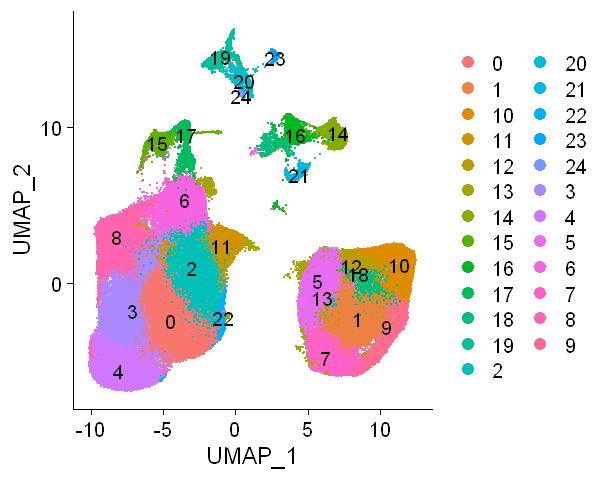

In [47]:
options(repr.plot.width=5, repr.plot.height=4)
DimPlot(object = immune.combined, reduction = "umap", label = TRUE)

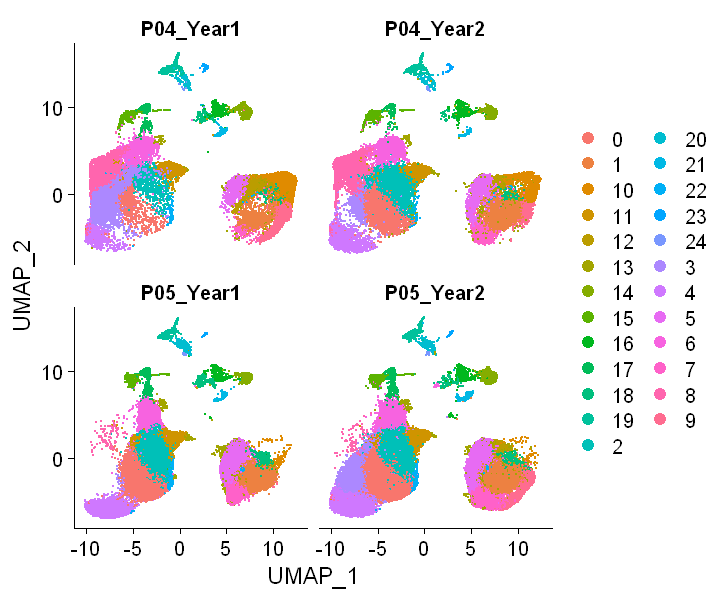

In [48]:
options(repr.plot.width=6, repr.plot.height=5)
DimPlot(object = immune.combined, reduction = "umap", split.by = "subject_year")

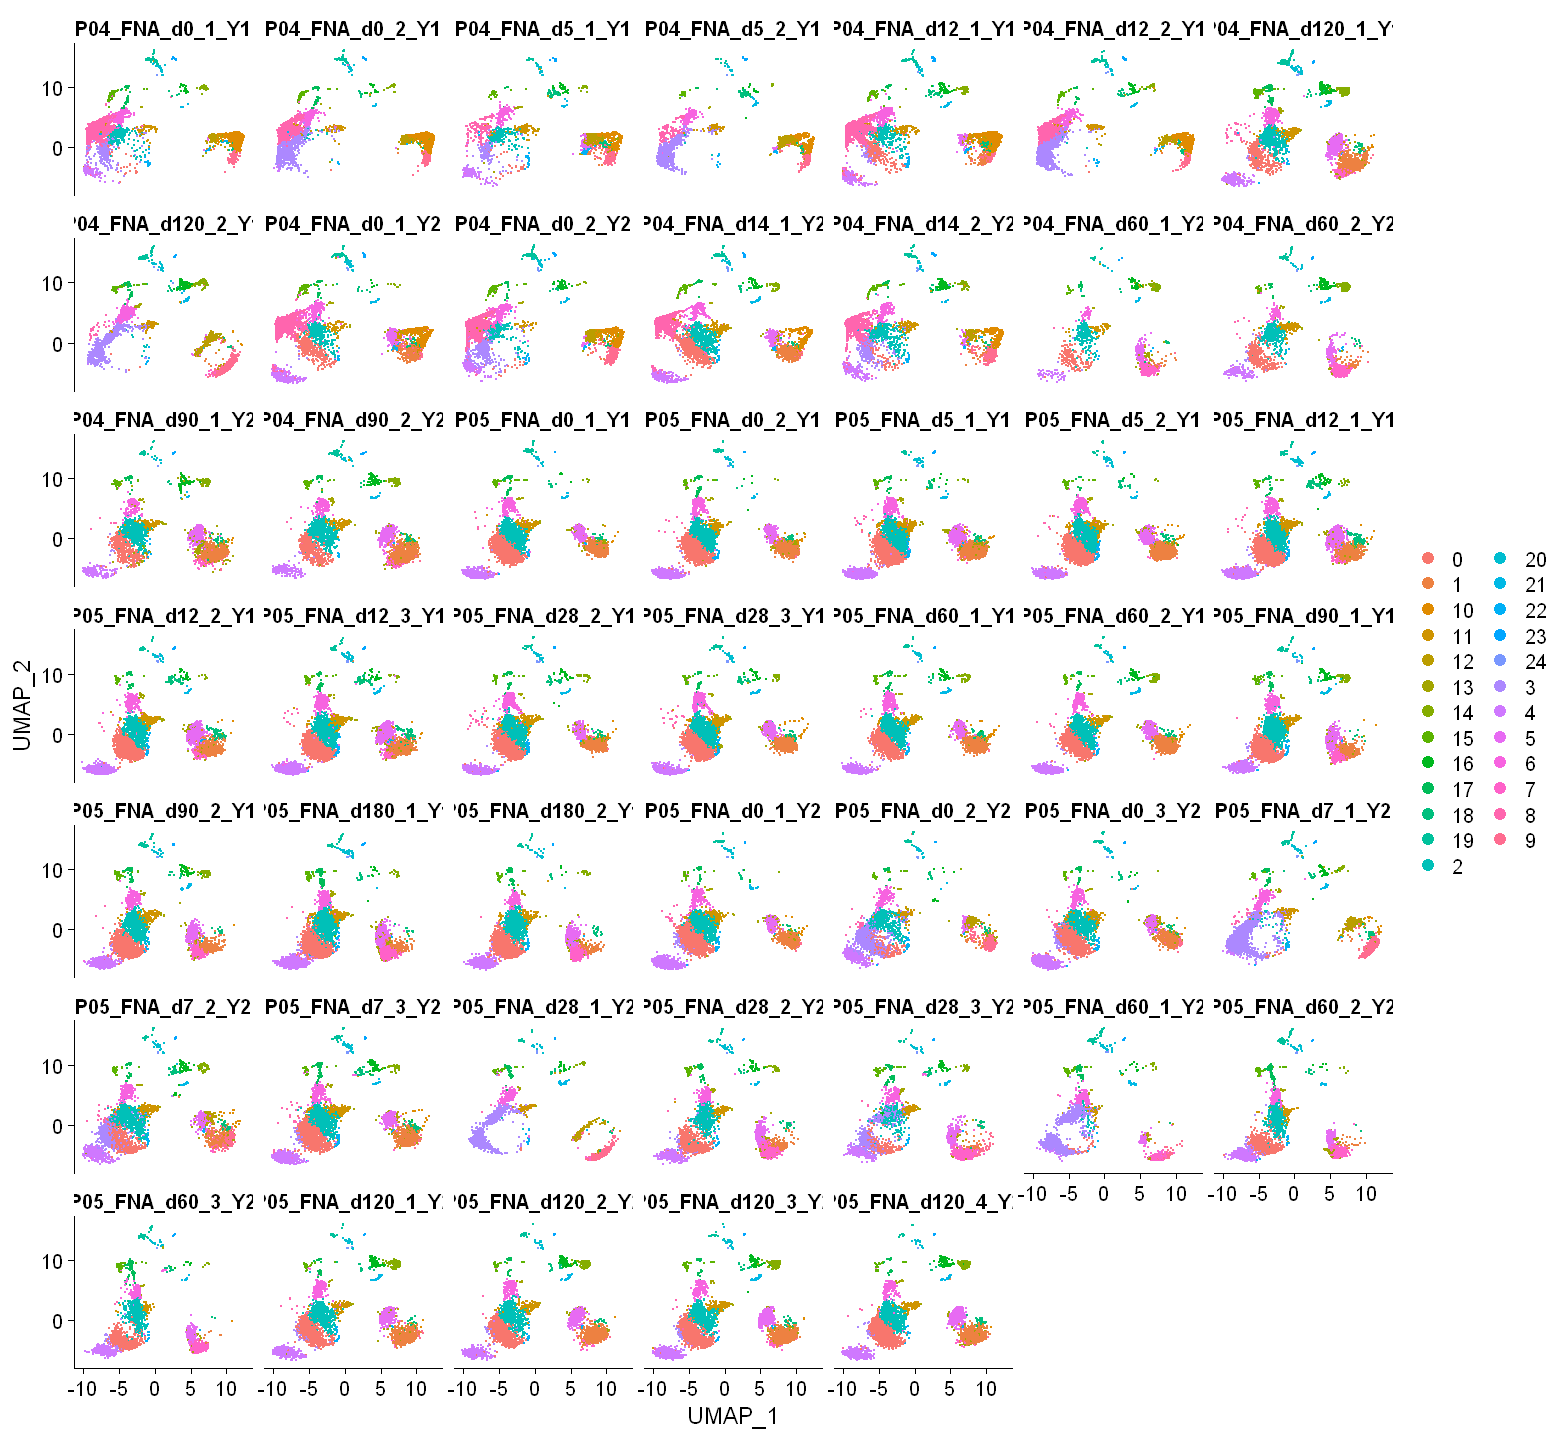

In [49]:
options(repr.plot.width=13, repr.plot.height=12)
DimPlot(object = immune.combined, reduction = "umap", split.by = "sampleName")

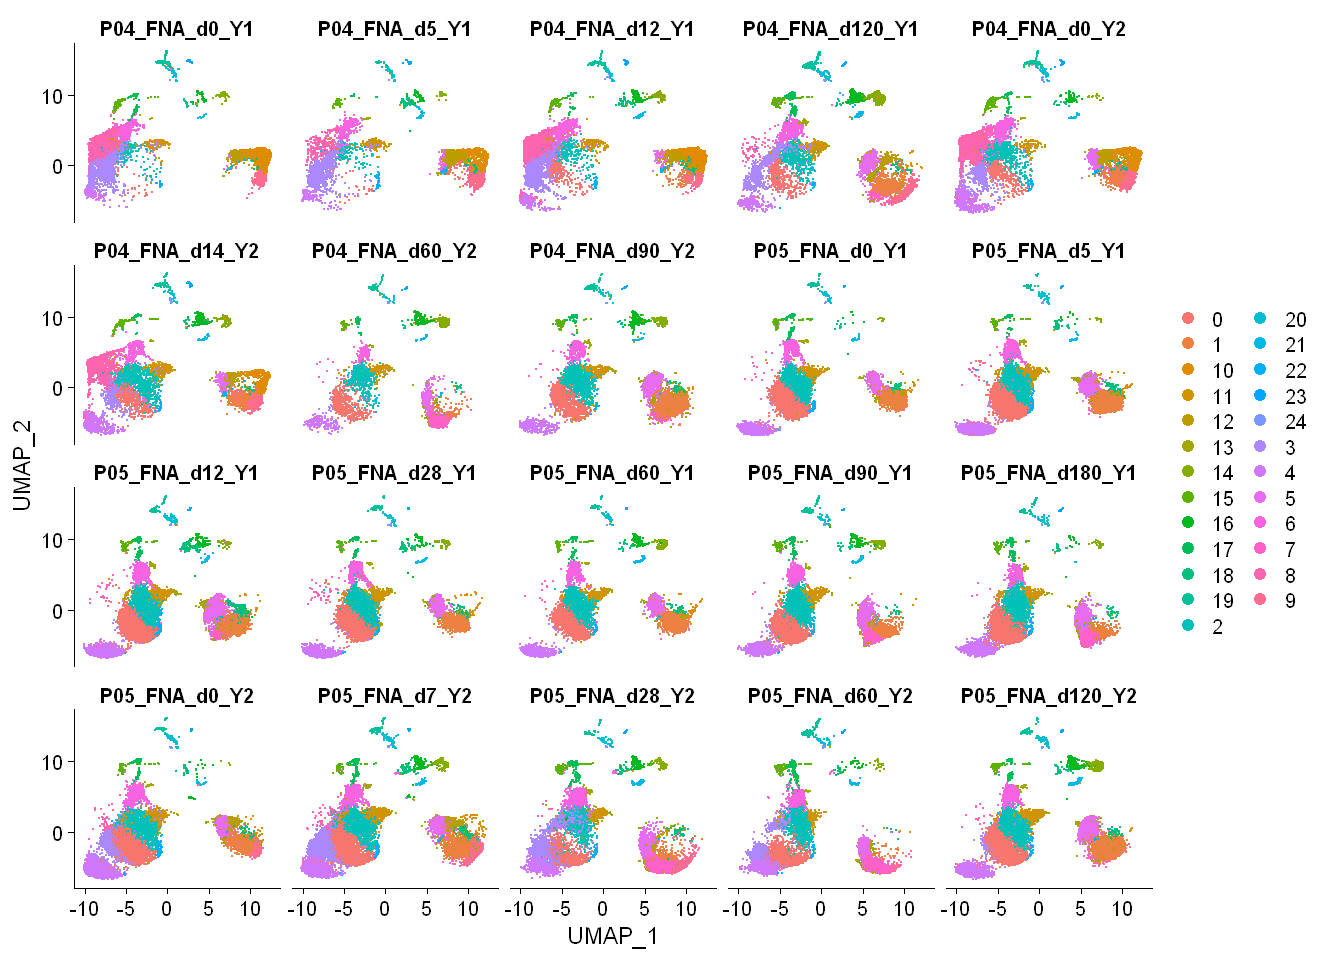

In [50]:
options(repr.plot.width=11, repr.plot.height=8)
DimPlot(object = immune.combined, reduction = "umap", split.by = "sampleName2")

## Check marker genes

In [51]:
B <- c("MS4A1", "IGKC","CD79A", "CD79B", "CD19")
RMB <- c("TNFRSF13B", "CD27", "CD24") #Resting Memory B
naive.B <- c("TCL1A", "IL4R",  "CCR7", "IGHM", "IGHD") #Naive B
plasma <- c("CD38", "CD27","FKBP11","TRIB1","SDC1","XBP1", "IRF4", "SEC11C", "JCHAIN", "PRDM1")
GC.B <- c("BCL6", "RGS13", "MEF2B", "STMN1", "ELL3", "SERPINA9")
ABC <- c("TBX21", "FCRL5", "ITGAX", "NKG7", "ZEB2", "CR2")# the lack of CR2 for activated B cells (ABCs);
T <- c("CD3D", "CD3E","CD4", "IL7R", "CD8A")
NK <- c("GZMB", "GNLY", "NKG7", "NCAM1")
CD14.Monocyte <-c("CD14","LYZ")
DC <- c("FCER1A", "CST3")
platlet <- "PPBP"
dividing  <- c("MKI67", "CDK1") # Dividing cells 
  
all.markers = unique(c(B, RMB, naive.B, plasma, GC.B, ABC, T, NK, CD14.Monocyte, DC, platlet, dividing))
            

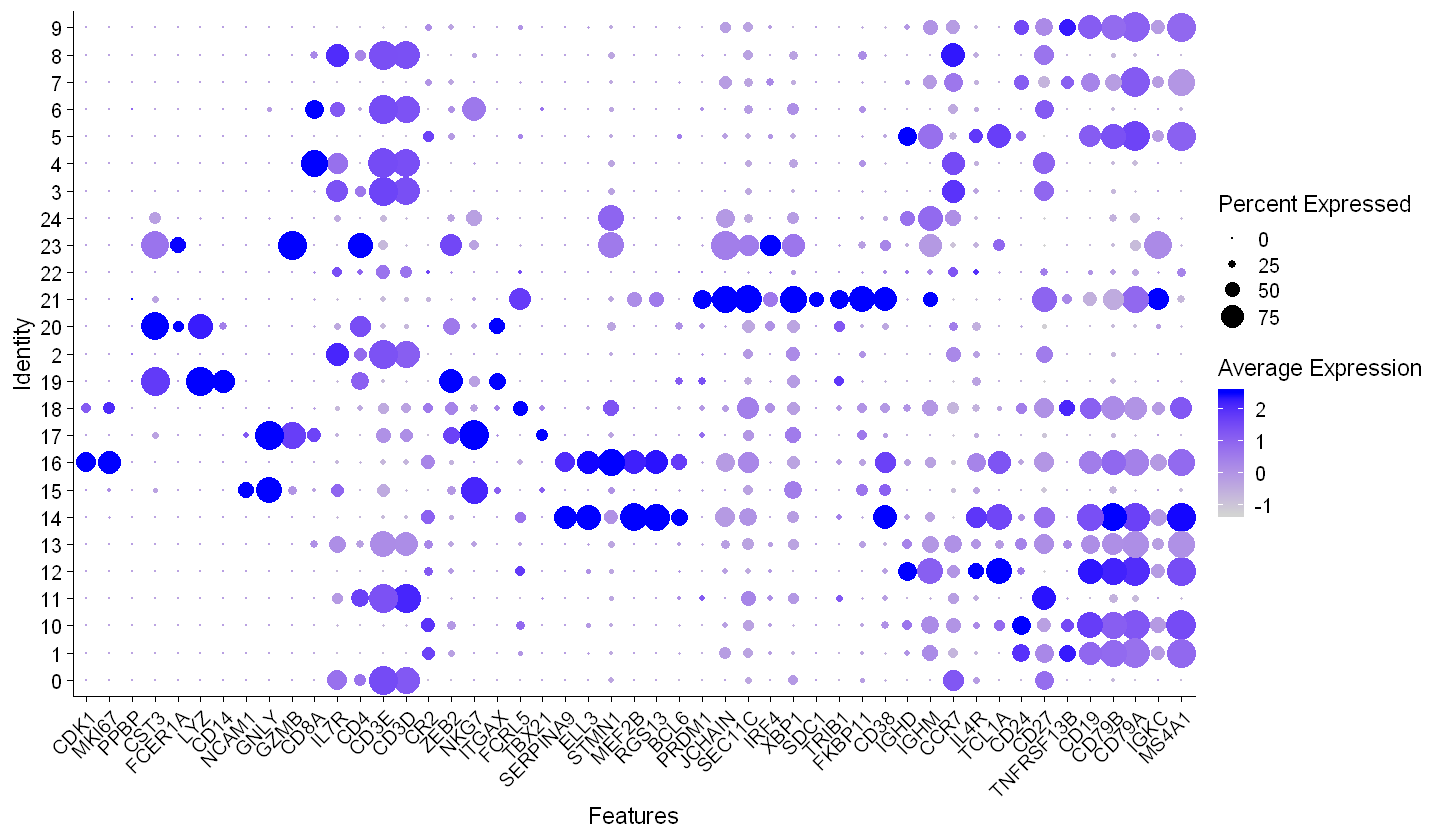

In [52]:
options(repr.plot.width=12, repr.plot.height=7)
DotPlot(immune.combined, assay = "RNA", features =  unique(all.markers), dot.scale = 8) + RotatedAxis()

### B cell markers

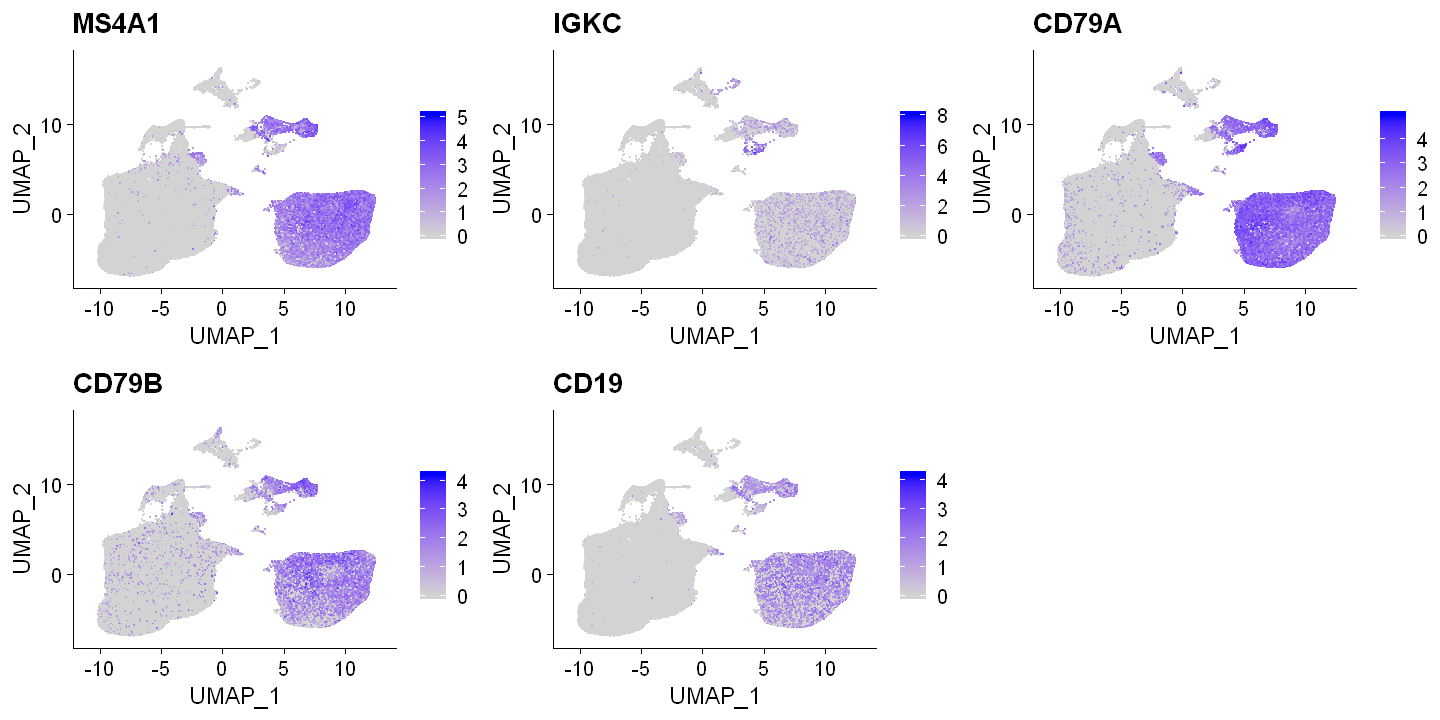

In [53]:
options(repr.plot.width=12, repr.plot.height=6)
FeaturePlot(object = immune.combined, features = B, ncol =3,cols = feature.cols, min.cutoff = 0)

### Plasma markers

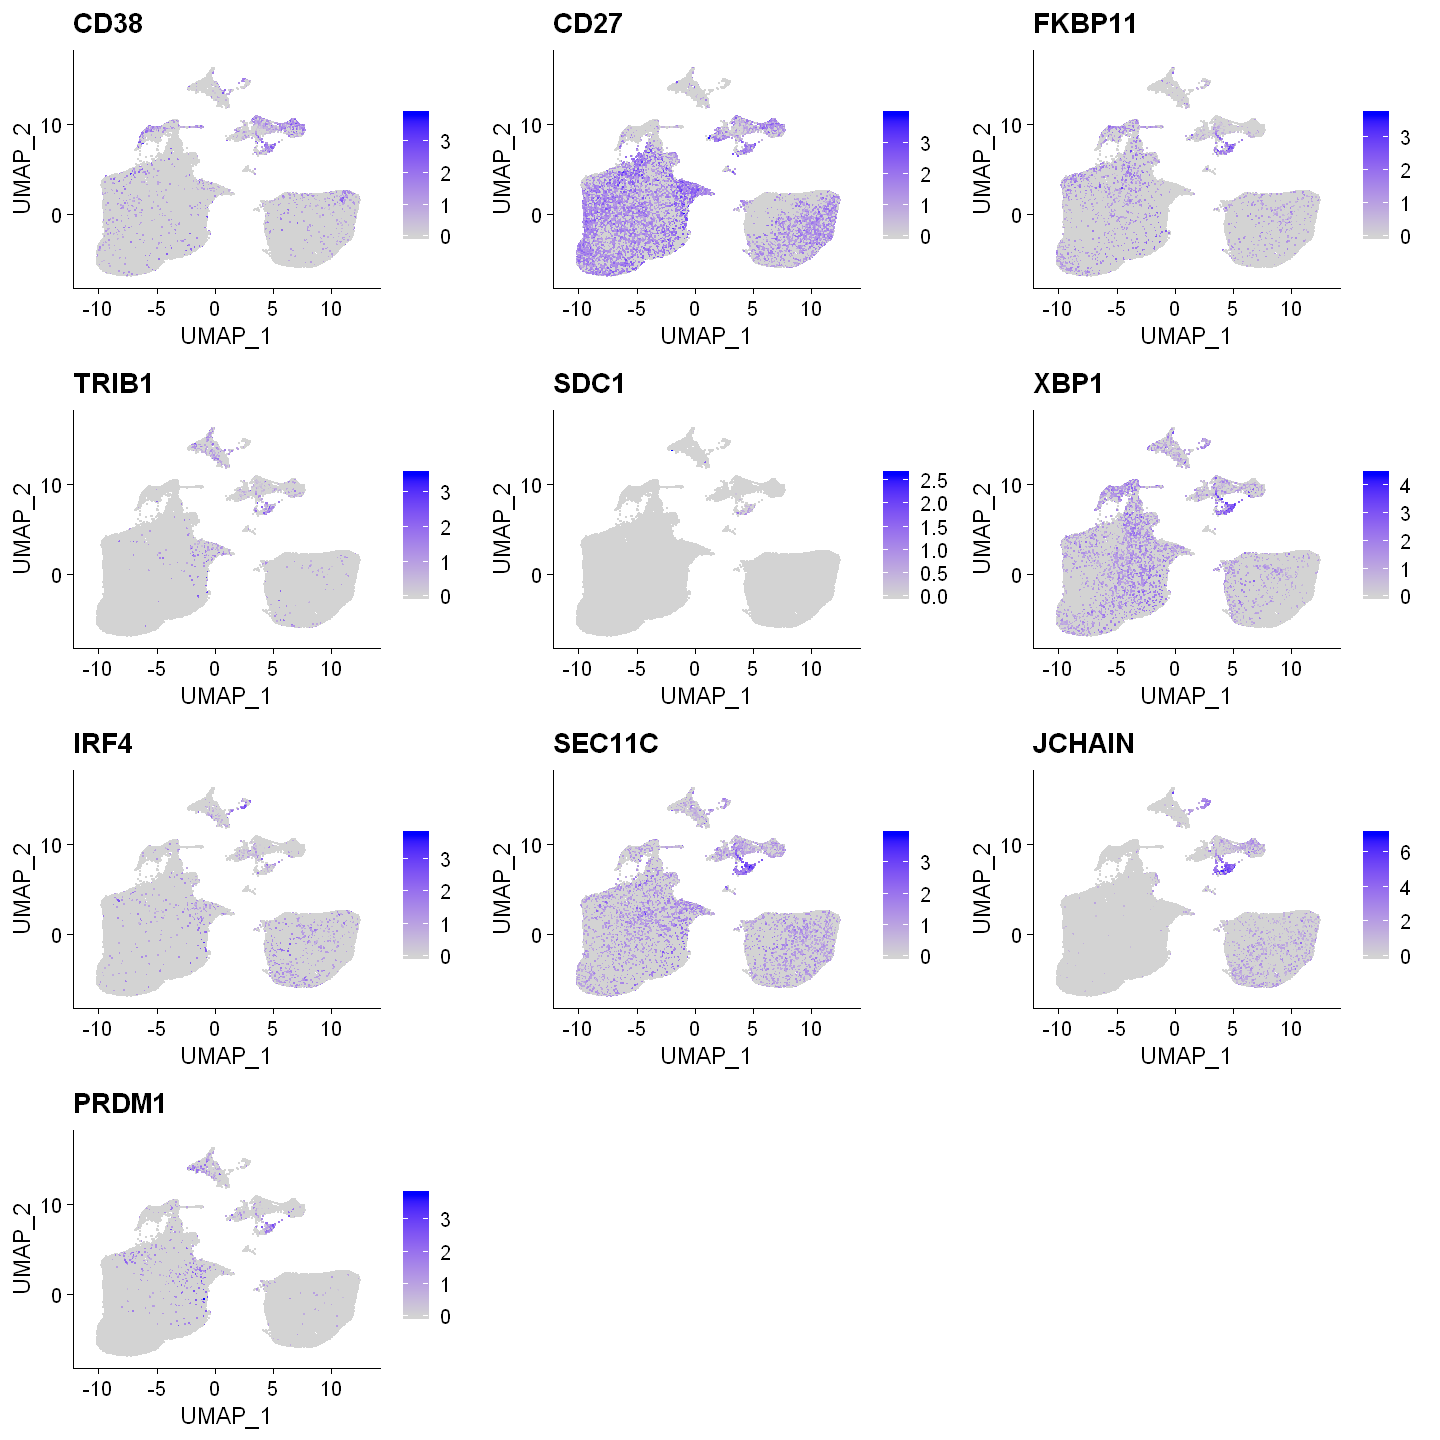

In [54]:
options(repr.plot.width=12, repr.plot.height=12)
FeaturePlot(object = immune.combined, features = plasma, ncol =3,cols = feature.cols, min.cutoff = 0)

### Resting Memory B cells

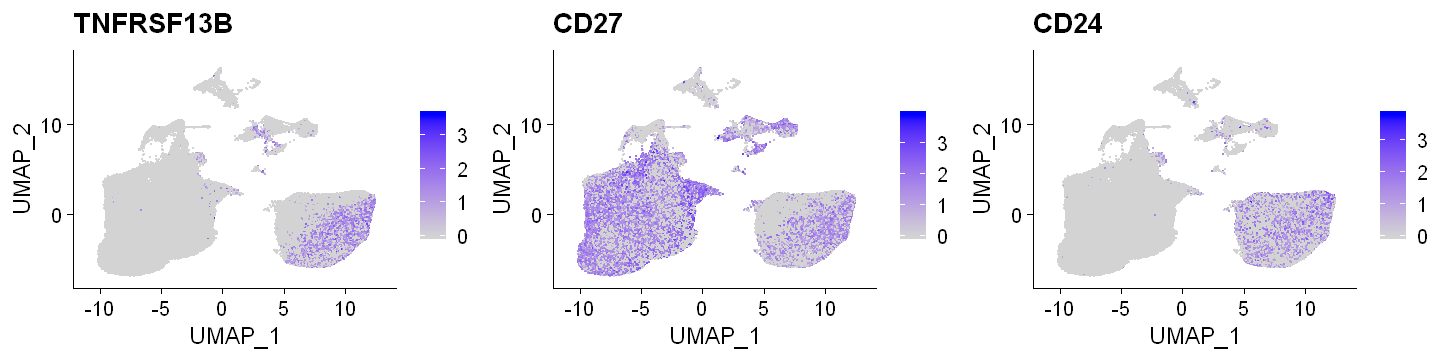

In [55]:
options(repr.plot.width=12, repr.plot.height=3)
FeaturePlot(object = immune.combined, features = RMB, ncol =3,cols = feature.cols, min.cutoff = 0)

### Naive B cells

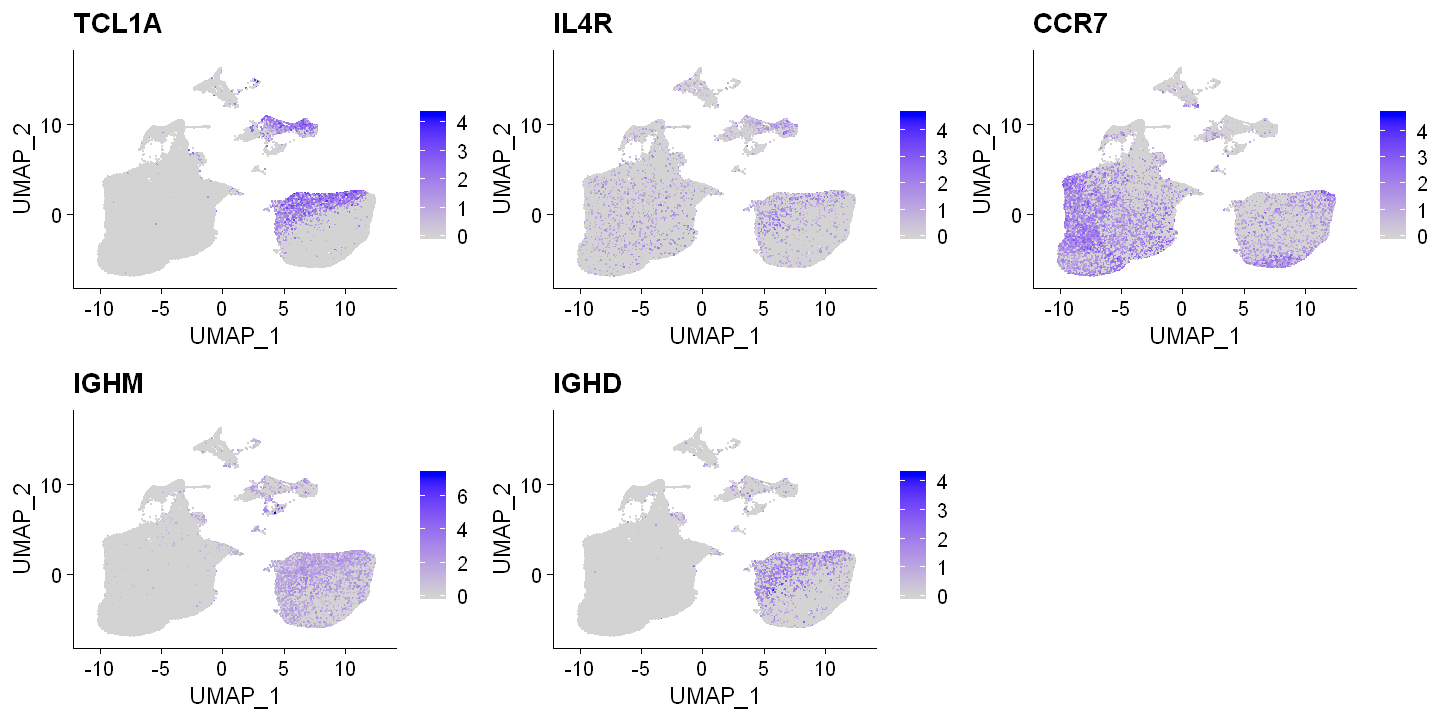

In [56]:
options(repr.plot.width=12, repr.plot.height=6)
FeaturePlot(object = immune.combined, features = naive.B, ncol =3,cols = feature.cols, min.cutoff = 0)

### Germinal Center B cells

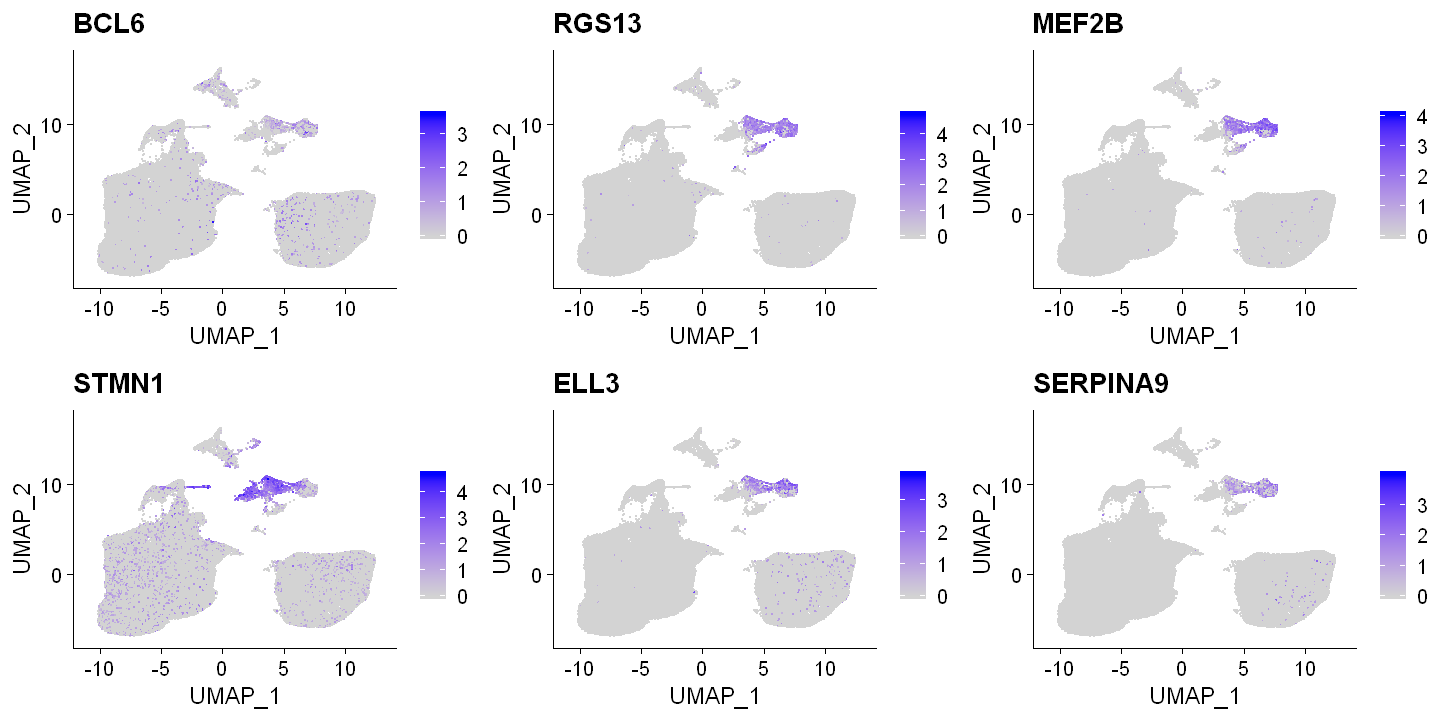

In [57]:
options(repr.plot.width=12, repr.plot.height=6)
FeaturePlot(object = immune.combined, features = GC.B, ncol =3,cols = feature.cols, min.cutoff = 0)

### Activated B cells

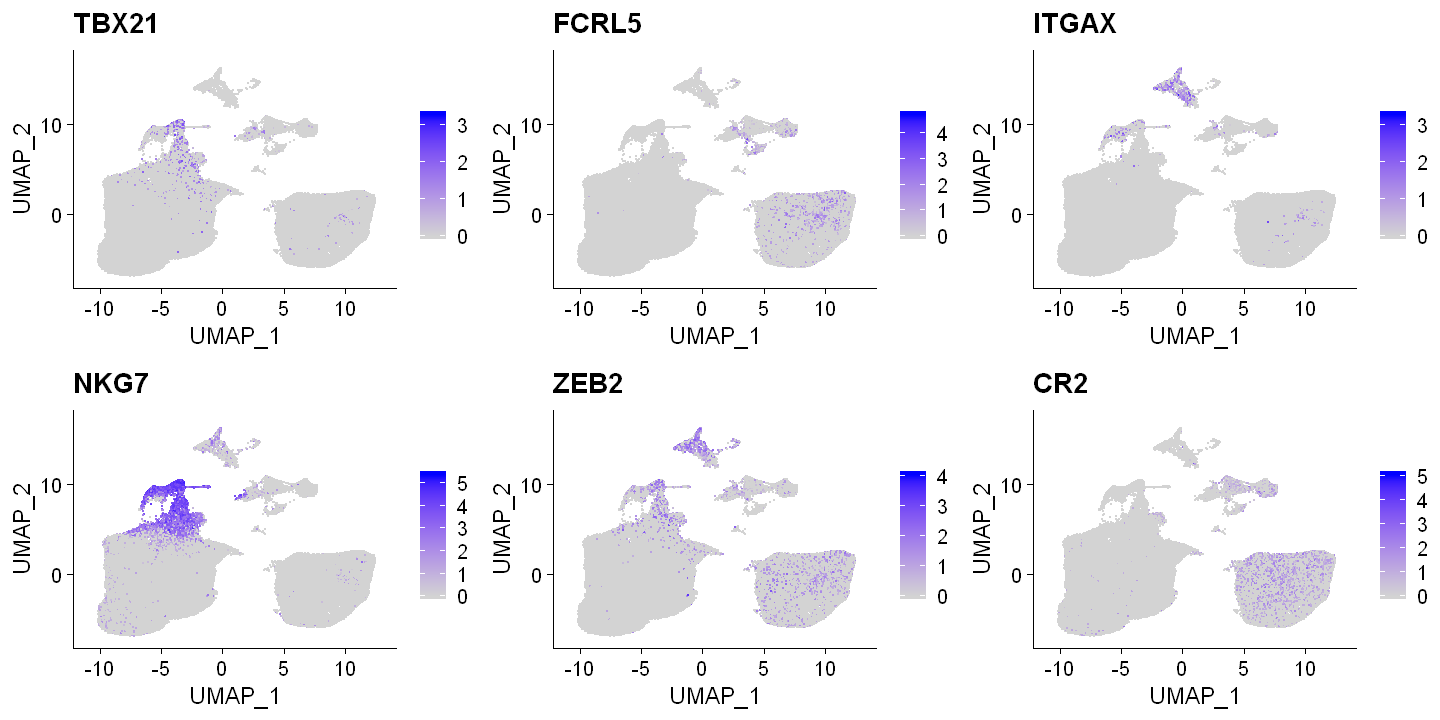

In [58]:
options(repr.plot.width=12, repr.plot.height=6)
FeaturePlot(object = immune.combined, features = ABC, ncol =3,cols = feature.cols, min.cutoff = 0)

### T cell markers

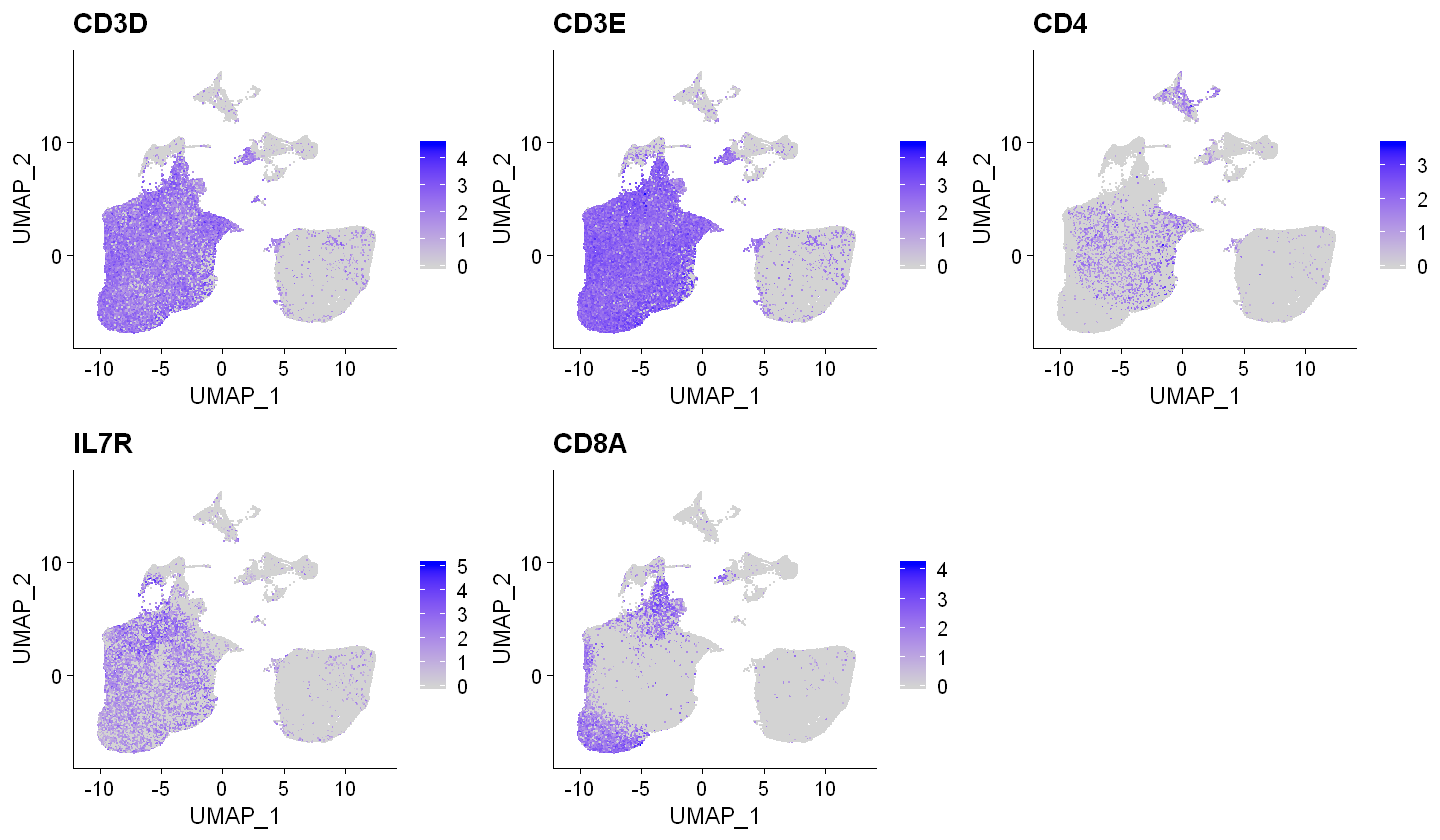

In [59]:
options(repr.plot.width=12, repr.plot.height=7)
FeaturePlot(object = immune.combined, features = T, ncol =3,cols = feature.cols, min.cutoff = 0)

### NK cell markers

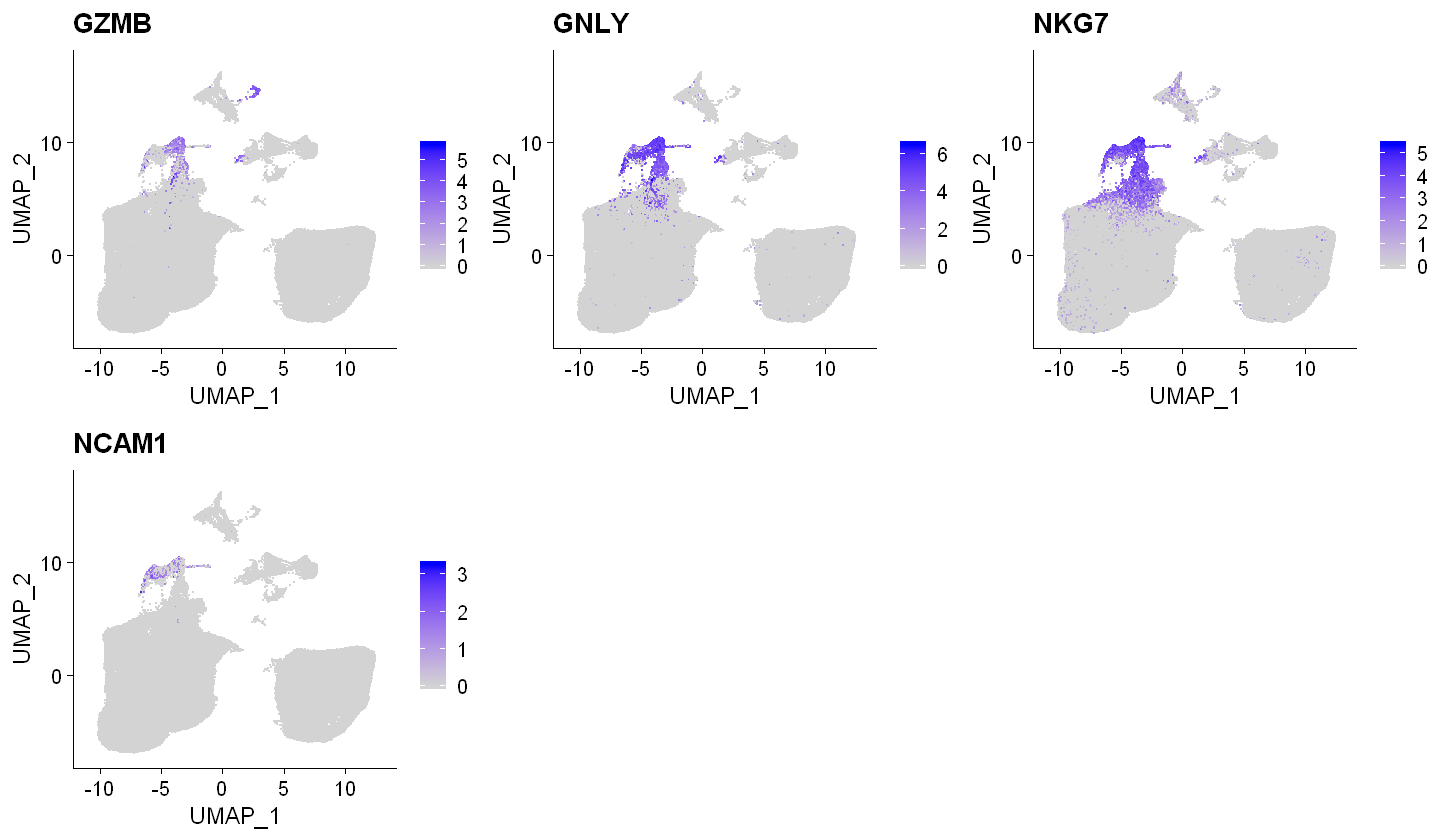

In [60]:
options(repr.plot.width=12, repr.plot.height=7)
FeaturePlot(object = immune.combined, features = NK, ncol =3,cols = feature.cols, min.cutoff = 0)

### DC cell markers

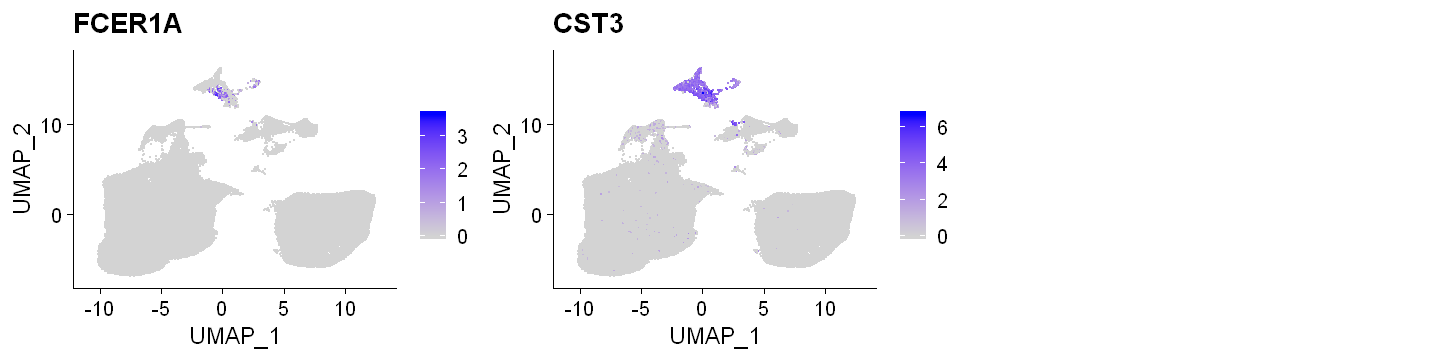

In [61]:
options(repr.plot.width=12, repr.plot.height=3)
FeaturePlot(object = immune.combined, features = DC, ncol =3,cols = feature.cols, min.cutoff = 0)

### CD14 Monocyte

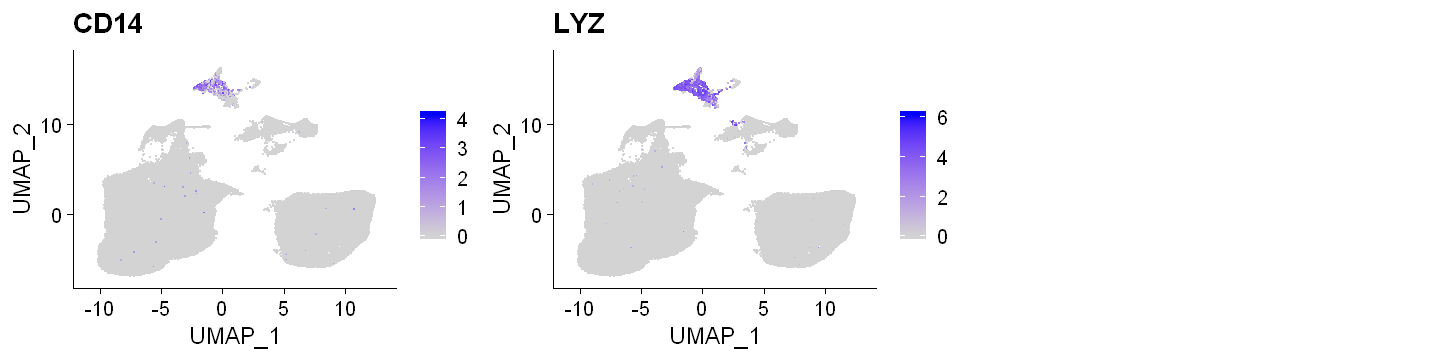

In [62]:
options(repr.plot.width=12, repr.plot.height=3)
FeaturePlot(object = immune.combined, features = CD14.Monocyte, ncol =3,cols = feature.cols, min.cutoff = 0)

### Dividing cells

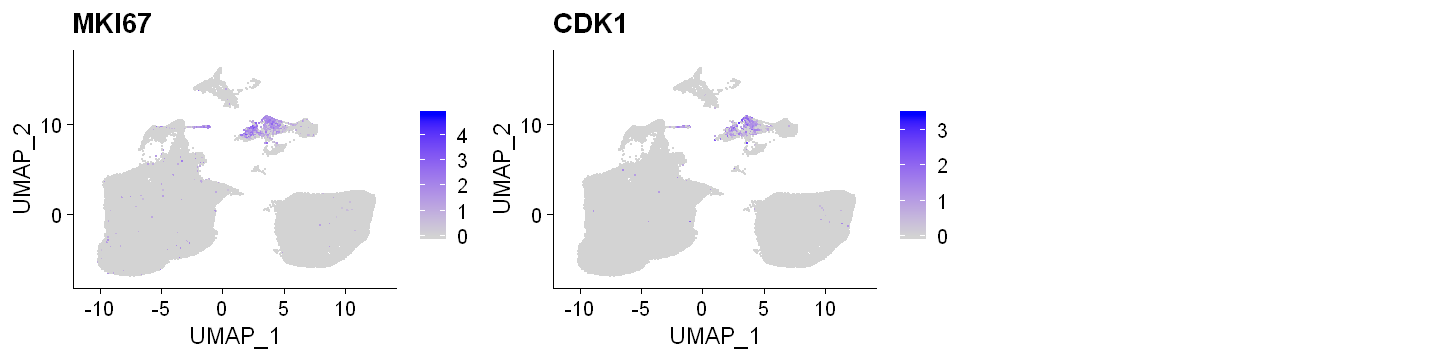

In [63]:
options(repr.plot.width=12, repr.plot.height=3)
FeaturePlot(object = immune.combined, features = dividing, ncol =3,cols = feature.cols, min.cutoff = 0)

# Cell type assignment by Immunostates

In [64]:
identities <- unique(Idents(immune.combined))
assignment_list <- list()
for(identity in identities){
    # mean expression of each gene in each cluster
    identity_cells <- data.frame(IDENTITY = Idents(immune.combined)) %>% 
        tibble::rownames_to_column("CELL") %>%
        filter(IDENTITY == identity) %>% select(CELL) %>% unlist()
    identity_obj <- subset(immune.combined, cells = identity_cells)
    #identity_mean_df <- data.frame(GetAssayData(object = identity_obj, slot = 'scale.data')) %>%
    #identity_mean_df <- data.frame(log(identity_obj@assays$RNA@counts+1) ) %>%
    identity_mean_df <- data.frame(identity_obj@assays$RNA@data) %>% # this data slot has normalized data
        tibble::rownames_to_column("GENE") %>%
        gather("CELL", "EXPR", -GENE) %>% 
        group_by(GENE) %>%
        summarize(EXPR_CLUSTER = mean(EXPR))
    
    # correlations of immunostate vectors with mean gene expression
    assignment_list[[identity]] <- immunostates %>%
        left_join(identity_mean_df, by="GENE") %>%
        drop_na(EXPR_CLUSTER) %>%
        filter(EXPR_CLUSTER != 0) %>%
        group_by(KNOWN) %>%
        summarize(COR = cor(EXPR,EXPR_CLUSTER))
}

Warning message:
"Column `GENE` joining factor and character vector, coercing into character vector"Warning message:
"Column `GENE` joining factor and character vector, coercing into character vector"Warning message:
"Column `GENE` joining factor and character vector, coercing into character vector"Warning message:
"Column `GENE` joining factor and character vector, coercing into character vector"Warning message:
"Column `GENE` joining factor and character vector, coercing into character vector"Warning message:
"Column `GENE` joining factor and character vector, coercing into character vector"Warning message:
"Column `GENE` joining factor and character vector, coercing into character vector"Warning message:
"Column `GENE` joining factor and character vector, coercing into character vector"Warning message:
"Column `GENE` joining factor and character vector, coercing into character vector"Warning message:
"Column `GENE` joining factor and character vector, coercing into character vector"

In [65]:
assignment_df <- bind_rows(assignment_list, .id = "IDENTITY") %>% 
    group_by(IDENTITY) %>% 
    filter(COR == max(COR)) %>%
    arrange(as.numeric(IDENTITY))

assignment_df

IDENTITY KNOWN                          COR      
1  0        CD4_positive_alpha_beta_T_cell 0.6690503
2  1        naive_B_cell                   0.6472482
3  2        CD4_positive_alpha_beta_T_cell 0.6906249
4  3        CD4_positive_alpha_beta_T_cell 0.6384677
5  4        CD8_positive_alpha_beta_T_cell 0.6893695
6  5        naive_B_cell                   0.6742555
7  6        CD8_positive_alpha_beta_T_cell 0.7053568
8  7        naive_B_cell                   0.5596872
9  8        CD4_positive_alpha_beta_T_cell 0.6775047
10 9        naive_B_cell                   0.6257740
11 10       naive_B_cell                   0.6868037
12 11       CD4_positive_alpha_beta_T_cell 0.7005111
13 12       naive_B_cell                   0.6742584
14 13       CD8_positive_alpha_beta_T_cell 0.5702669
15 14       naive_B_cell                   0.6828337
16 15       CD56bright_natural_killer_cell 0.6649422
17 16       naive_B_cell                   0.6883427
18 17       CD8_positive_alpha_beta_T_cell 0.6999132
19 18       memory_B_cell                  0.6813861
20 19       CD14_positive_monocyte         0.6972303
21 20       myeloid_dendritic_cell         0.6153076
22 21       plasma_cell                    0.5913852
23 22       CD4_positive_alpha_beta_T_cell 0.5922512
24 23       naive_B_cell                   0.4195154
25 24       CD56dim_natural_killer_cell    0.5304246

In [69]:
# save for future use
saveRDS(immune.combined, file.path(path.work, "FNA.GEX.Y1Y2.rds"))
#immune.combined <- readRDS("FNA.GEX.rds")

### CLuster 14 and 16 are GCs

In [66]:
immune.combined.GC <- subset(immune.combined, idents = c('14','16'))

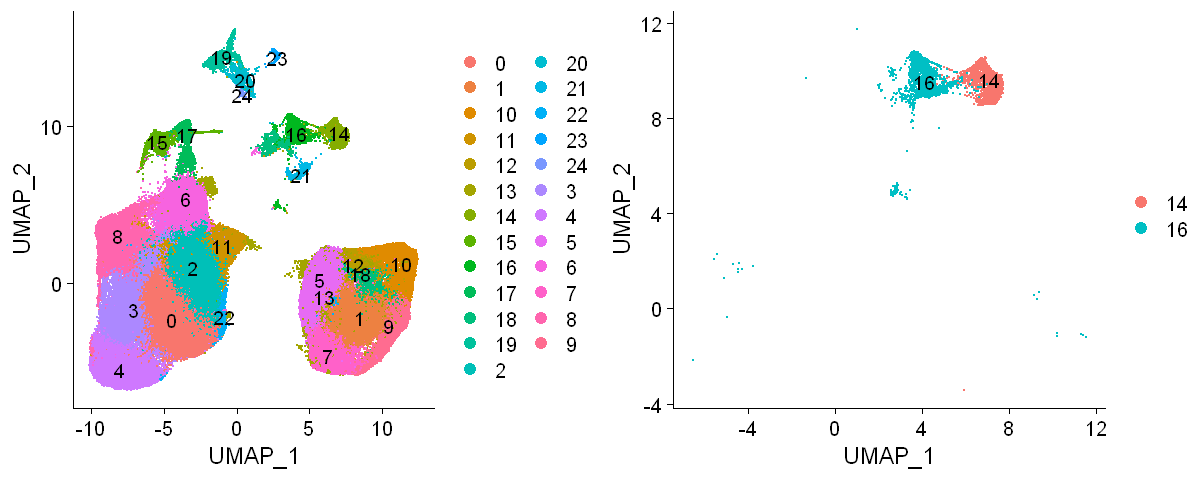

In [68]:
options(repr.plot.width=10, repr.plot.height=4)
p1 = DimPlot(object = immune.combined, reduction = "umap", label = TRUE)
p2 = DimPlot(object = immune.combined.GC, reduction = "umap", label = TRUE)
plot_grid(p1, p2)

In [2]:
#saveRDS(immune.combined.GC, file.path(path.work, "FNA.GEX.GCCluster.Y1Y2.rds"))
immune.combined <- readRDS("FNA.GEX.Y1Y2.rds")

In [4]:
path.data = file.path("D:","Storage","Ali","10x","Year2","mergeBCR_Y1Y2","data")
BCR.Y1Y2.P04 = read.table(paste0(path.data, "/P04_p.tsv"), header=TRUE, sep="\t",as.is=T,stringsAsFactors = FALSE)
BCR.Y1Y2.P05 = read.table(paste0(path.data, "/P05_p.tsv"), header=TRUE, sep="\t",as.is=T,stringsAsFactors = FALSE)

BCR.Y1Y2.P04 = BCR.Y1Y2.P04 %>% 
        dplyr::filter(SAMPLETYPE == "FNA"  & DATATYPE == "singleCell") 
BCR.Y1Y2.P05 = BCR.Y1Y2.P05 %>% 
        dplyr::filter(SAMPLETYPE == "FNA"  & DATATYPE == "singleCell")
BCR.Y1Y2 = rbind(BCR.Y1Y2.P04, BCR.Y1Y2.P05)

BCR.Y1Y2 = BCR.Y1Y2 %>% rowwise() %>%
            mutate(BARCODE = paste(SAMPLE, strsplit(CELL, split = "-")[[1]][1], sep = "_"))

b_cell.BM <- unique((BCR.Y1Y2 %>%
            filter(BARCODE %in% Cells(immune.combined)))$BARCODE)

length(b_cell.BM)
 

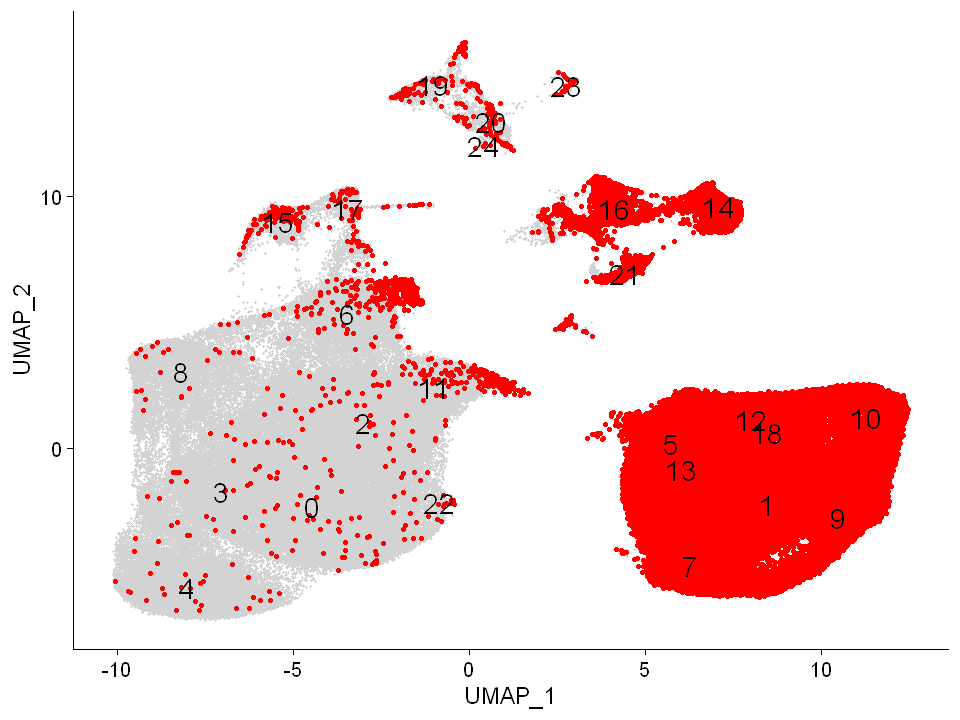

In [6]:
options(repr.plot.width=8, repr.plot.height=6)
DimPlot(object = immune.combined, reduction = "umap", cells.highlight = b_cell.BM, label = TRUE, 
        pt.size = 0.5,label.size=6, cols=feature.cols) + NoLegend()

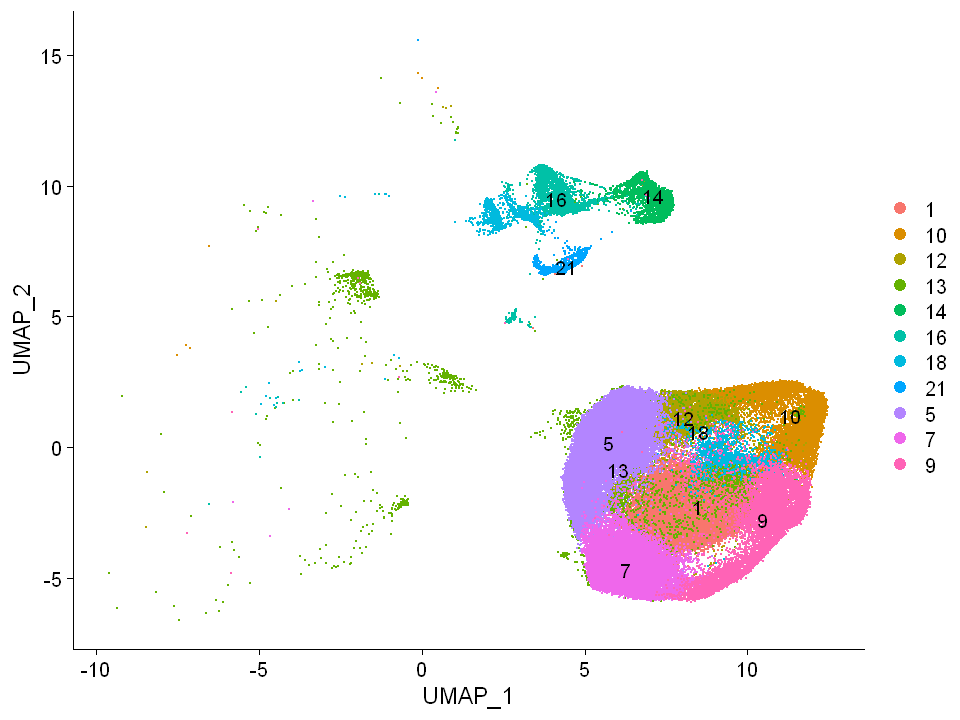

In [7]:
immune.combined.B <- subset(immune.combined, idents = c('1','5','7','9','10','12','13','14','16','18','21'))
DimPlot(object = immune.combined.B, reduction = "umap", label = TRUE)

In [8]:
saveRDS(immune.combined.B, file.path(path.work, "FNA.GEX.pre_B.Y1Y2.rds"))